In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from functools import partial
from itertools import combinations

import numpy as np
import jax
from jax import random
from jax import numpy as jnp
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import distrax
import wandb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import src.models as models
from src.models import make_PoG_Ens_loss, make_Reg_Ens_loss, make_PoN_Ens_loss
from src.models import make_PoG_Ens_plots, make_Reg_Ens_plots, make_PoN_Ens_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.comparison_figures_pog import get_config as get_pog_config
from experiments.configs.comparison_figures_reg_ens import get_config as get_reg_ens_config
from experiments.configs.comparison_figures_pon import get_config as get_pon_config
from src.models.pog import calculate_pog_loc_scale
from src.models.reg_ens import calculate_ens_loc_scale
from src.models.pon import normal_prod

In [3]:
ENS_RETRAIN = False
POG_RETRAIN = False
PON_RETRAIN = False

In [4]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'reg_comparison_figures.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


True

## PoG Training

In [5]:
config = get_pog_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_pog_states = []
for i in range(3):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    pog_model, state = setup_training(config, setup_rng, init_x, init_y)

    if POG_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            pog_model, state, config, rng, partial(make_PoG_Ens_loss, per_member_loss=True), partial(make_PoG_Ens_loss, per_member_loss=True), train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_PoG_Ens_plots,
        )

        best_pog_states.append(best_state)

        save_checkpoint(f'dynNN_results/pog_model_{i}', best_state, 1, overwrite=True)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [6]:
# if POG_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/pog_models', best_pog_states, 1)

## Reg Ens training

In [7]:
config = get_reg_ens_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_ens_states = []
for i in range(3):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    ens_model, state = setup_training(config, setup_rng, init_x, init_y)

    if ENS_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            ens_model, state, config, rng, make_Reg_Ens_loss, make_Reg_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_Reg_Ens_plots,
        )

        best_ens_states.append(best_state)

        save_checkpoint(f'dynNN_results/ens_model_{i}', best_ens_states, 1, overwrite=True)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [8]:
# if ENS_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/ens_models', best_ens_states, 1, overwrite=True)

## PoN

In [9]:
config = get_pon_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_pon_states = []
for i in range(3):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    pon_model, state = setup_training(config, setup_rng, init_x, init_y)

    if PON_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            pon_model, state, config, rng, make_PoN_Ens_loss, make_PoN_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_PoN_Ens_plots,
        )

        best_pon_states.append(best_state)

        save_checkpoint(f'dynNN_results/pon_model_{i}', best_pon_states, 1, overwrite=True)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [10]:
# if PON_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/pon_models', best_pon_states, 1, overwrite=True)

## Paper Plots

In [29]:
# restored_pog_models = restore_checkpoint('dynNN_results/pog_models', 1)
restored_pog_models = {f'{i}': restore_checkpoint(f'dynNN_results/pog_model_{i}', 1) for i in range(3)}
restored_ens_models = restore_checkpoint('dynNN_results/ens_model_2', 1)
# restored_ens_models = {f'{i}': restore_checkpoint(f'dynNN_results/ens_model_{i}', 1) for i in range(3)}
restored_pon_models = restore_checkpoint('dynNN_results/pon_model_2', 1)
# restored_pon_models = {f'{i}': restore_checkpoint(f'dynNN_results/pon_model_{i}', 1) for i in range(3)}

In [30]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_202702/821981954.py:20: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [31]:
X_test, y_test = list(zip(*test_loader.dataset))

In [32]:
def uniform_entropy(loc, scale):
    upper = loc + scale
    lower = loc - scale
    # return jnp.log(upper - lower)
    uni = distrax.Uniform(lower, upper)
    return uni.entropy()

def uniform_nll(loc, scale, y):
    upper = loc + scale
    lower = loc - scale
    # return jnp.log(upper - lower)
    uni = distrax.Uniform(lower, upper)
    return -uni.log_prob(y)

In [33]:
def normal_entropy(loc, scale):
    norm = distrax.Normal(loc, scale)
    return norm.entropy()

def normal_nll(loc, scale, y):
    norm = distrax.Normal(loc, scale)
    return -norm.log_prob(y)

In [34]:
def mse(loc, y):
    return jnp.mean((loc - y)**2)

In [35]:
results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'mse', 'nll'])
results_df

,model_name,n_members,random_seed,H,mse,nll


In [36]:
s = set(range(5))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

for (model, model_name) in [(pog_model, 'PoG'), (ens_model, 'Ens'), (pon_model, 'PoN')]:
    for i in range(3):
        if model_name == 'PoG':
            state = restored_pog_models[f'{i}']
        elif model_name == 'Ens':
            state = restored_ens_models[f'{i}']
        elif model_name == 'PoN':
            state = restored_pon_models[f'{i}']
        
        pred_fun = partial(
            model.apply,
            {"params": state['params'], **state['model_state']},
            train=False, return_ens_preds=True,
            method=model.pred
        )
        _, (locs, scales) = jax.vmap(
            pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
        )(jnp.array(X_test))

        for indices in power_set:
            n_members = len(indices)

            if model_name == 'PoG':
                loc, scale = calculate_pog_loc_scale(locs[indices, :, 0], scales[indices, :, 0])
                entropies = jax.vmap(uniform_entropy)(loc, scale)
                nlls_ = jax.vmap(uniform_nll)(loc, scale, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                print(f"dropping {infs.sum()} infs for prod of {n_members}")
                nlls = nlls_[~infs]
            elif model_name == 'Ens':
                loc, scale = calculate_ens_loc_scale(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                entropies = jax.vmap(normal_entropy)(loc, scale)
                nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
            elif model_name == 'PoN':
                loc, scale = normal_prod(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                entropies = jax.vmap(normal_entropy)(loc, scale)
                nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
            
            errors = jax.vmap(mse)(loc, jnp.array(y_test))

            results_df = pd.concat([
                results_df,
                pd.DataFrame({
                    'model_name': [model_name],
                    'n_members': [n_members],
                    'random_seed': [i],
                    'H': [entropies.mean()],
                    'nll': [nlls.mean()],
                    'mse': [errors.mean()],
                })],
                ignore_index=True
            )

dropping 18 infs for prod of 1
dropping 1 infs for prod of 1
dropping 3 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 19 infs for prod of 2
dropping 21 infs for prod of 2
dropping 18 infs for prod of 2
dropping 19 infs for prod of 2
dropping 4 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 3 infs for prod of 2
dropping 4 infs for prod of 2
dropping 1 infs for prod of 2
dropping 22 infs for prod of 3
dropping 19 infs for prod of 3
dropping 20 infs for prod of 3
dropping 21 infs for prod of 3
dropping 22 infs for prod of 3
dropping 19 infs for prod of 3
dropping 4 infs for prod of 3
dropping 5 infs for prod of 3
dropping 2 infs for prod of 3
dropping 4 infs for prod of 3
dropping 22 infs for prod of 4
dropping 23 infs for prod of 4
dropping 20 infs for prod of 4
dropping 22 infs for prod of 4
dropping 5 infs for prod of 4
dropping 23 infs for prod of 5
dropping 0 infs for prod of 1
dropping 3 infs for prod

In [37]:
min_mse_df = results_df[results_df.n_members == 5][['model_name', 'random_seed', 'mse', 'nll']].rename(
    columns={'mse': 'final_mse', 'nll': 'final_nll'}
)
min_mse_df

,model_name,random_seed,final_mse,final_nll
30,PoG,0,0.036683664,-0.51891834
61,PoG,1,0.03365107,-0.35098374
92,PoG,2,0.03170089,-0.36378577
123,Ens,0,0.03049054,0.3942372
154,Ens,1,0.030725082,0.28992727
185,Ens,2,0.029938374,0.23560505
216,PoN,0,0.030490544,0.39236367
247,PoN,1,0.030725079,0.28255203
278,PoN,2,0.029938374,0.22834827


In [38]:
tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
tmp_df['mse_diff'] = tmp_df['mse'] - tmp_df['final_mse'] 
tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
tmp_df

,model_name,n_members,random_seed,H,mse,nll,final_mse,final_nll,mse_diff,nll_diff
0,PoG,1,0,0.40588135,0.25374058,0.4058814,0.036683664,-0.51891834,0.21705692,0.92479974
1,PoG,1,0,0.40588132,0.07960845,0.40588138,0.036683664,-0.51891834,0.042924784,0.9247997
2,PoG,1,0,0.40588135,0.2056683,0.40588135,0.036683664,-0.51891834,0.16898464,0.9247997
3,PoG,1,0,0.40588135,0.038486723,0.4058814,0.036683664,-0.51891834,0.0018030591,0.92479974
4,PoG,1,0,0.40588132,0.063762635,0.40588138,0.036683664,-0.51891834,0.027078971,0.9247997
...,...,...,...,...,...,...,...,...,...,...
274,PoN,4,2,0.660059,0.030405775,0.2294144,0.029938374,0.22834827,0.000467401,0.0010661334
275,PoN,4,2,0.660059,0.030580003,0.22981182,0.029938374,0.22834827,0.0006416291,0.0014635473
276,PoN,4,2,0.660059,0.029824967,0.22808957,0.029938374,0.22834827,-0.00011340715,-0.00025869906
277,PoN,4,2,0.660059,0.029201228,0.22666685,0.029938374,0.22834827,-0.00073714554,-0.0016814172


In [39]:
agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'mse_diff': ['mean', 'std', 'count'],
    'mse': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
})
agg_df

H                  mse_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.741582  0.079356    15  0.003172  0.004655    15   
           2          0.745333  0.076334    30  0.001189  0.001499    30   
           3          0.746620  0.075743    30  0.000529  0.000778    30   
           4          0.747298  0.076758    15  0.000198  0.000436    15   
           5          0.747722  0.090577     3  0.000000  0.000000     3   
PoG        1          0.348156  0.066051    15  0.071178  0.060036    15   
           2          0.043269  0.149843    30  0.027447  0.022107    30   
           3         -0.141305  0.159449    30  0.016966  0.014906    30   
           4         -0.297986  0.145657    15  0.008393  0.010063    15   
           5         -0.440560  0.088275     3  0.000000  0.000000     3   
PoN        1          0.741582  0.079356    15  0.003172  0.004655    15   
           2          0.741582  0.077976    30  0.001189  0.001499    30   
           3          0.741582  0.077976    30  0.000529  0.000778    30   
           4          0.741582  0.079356    15  0.000198  0.000436    15   
           5          0.741582  0.093896     3  0.000000  0.000000     3   

                           mse                  nll_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.033557  0.004670    15  0.001030  0.009451    15   
           2          0.031574  0.001539    30  0.000069  0.004768    30   
           3          0.030913  0.000849    30  0.000012  0.003169    30   
           4          0.030583  0.000555    15  0.000002  0.001982    15   
           5          0.030385  0.000404     3  0.000000  0.000000     3   
PoG        1          0.105190  0.060708    15  0.759385  0.129290    15   
           2          0.061459  0.022684    30  0.464214  0.165621    30   
           3          0.050978  0.015531    30  0.286520  0.162431    30   
           4          0.042405  0.010658    15  0.136438  0.137128    15   
           5          0.034012  0.002511     3  0.000000  0.000000     3   
PoN        1          0.033557  0.004670    15  0.006532  0.009973    15   
           2          0.031574  0.001539    30  0.002449  0.003260    30   
           3          0.030913  0.000849    30  0.001089  0.001680    30   
           4          0.030583  0.000555    15  0.000408  0.000928    15   
           5          0.030385  0.000404     3  0.000000  0.000000     3   

                           nll                  
                          mean       std count  
model_name n_members                            
Ens        1          0.307620  0.068330    15  
           2          0.306659  0.067057    30  
           3          0.306601  0.067007    30  
           4          0.306592  0.068159    15  
           5          0.306590  0.080618     3  
PoG        1          0.348156  0.066051    15  
           2          0.052985  0.145176    30  
           3         -0.124709  0.155588    30  
           4         -0.274792  0.144020    15  
           5         -0.411229  0.093481     3  
PoN        1          0.307620  0.068330    15  
           2          0.303537  0.068374    30  
           3          0.302177  0.068930    30  
           4          0.301496  0.070445    15  
           5          0.301088  0.083564     3

In [40]:
agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
agg_df[('mse_diff', 'std_err')] = agg_df[('mse_diff', 'std')] / agg_df[('mse_diff', 'count')]
agg_df[('mse', 'std_err')] = agg_df[('mse', 'std')] / agg_df[('mse', 'count')]
agg_df[('nll_diff', 'std_err')] = agg_df[('nll_diff', 'std')] / agg_df[('nll_diff', 'count')]
agg_df[('nll', 'std_err')] = agg_df[('nll', 'std')] / agg_df[('nll', 'count')]
agg_df

H                  mse_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.741582  0.079356    15  0.003172  0.004655    15   
           2          0.745333  0.076334    30  0.001189  0.001499    30   
           3          0.746620  0.075743    30  0.000529  0.000778    30   
           4          0.747298  0.076758    15  0.000198  0.000436    15   
           5          0.747722  0.090577     3  0.000000  0.000000     3   
PoG        1          0.348156  0.066051    15  0.071178  0.060036    15   
           2          0.043269  0.149843    30  0.027447  0.022107    30   
           3         -0.141305  0.159449    30  0.016966  0.014906    30   
           4         -0.297986  0.145657    15  0.008393  0.010063    15   
           5         -0.440560  0.088275     3  0.000000  0.000000     3   
PoN        1          0.741582  0.079356    15  0.003172  0.004655    15   
           2          0.741582  0.077976    30  0.001189  0.001499    30   
           3          0.741582  0.077976    30  0.000529  0.000778    30   
           4          0.741582  0.079356    15  0.000198  0.000436    15   
           5          0.741582  0.093896     3  0.000000  0.000000     3   

                           mse                  nll_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.033557  0.004670    15  0.001030  0.009451    15   
           2          0.031574  0.001539    30  0.000069  0.004768    30   
           3          0.030913  0.000849    30  0.000012  0.003169    30   
           4          0.030583  0.000555    15  0.000002  0.001982    15   
           5          0.030385  0.000404     3  0.000000  0.000000     3   
PoG        1          0.105190  0.060708    15  0.759385  0.129290    15   
           2          0.061459  0.022684    30  0.464214  0.165621    30   
           3          0.050978  0.015531    30  0.286520  0.162431    30   
           4          0.042405  0.010658    15  0.136438  0.137128    15   
           5          0.034012  0.002511     3  0.000000  0.000000     3   
PoN        1          0.033557  0.004670    15  0.006532  0.009973    15   
           2          0.031574  0.001539    30  0.002449  0.003260    30   
           3          0.030913  0.000849    30  0.001089  0.001680    30   
           4          0.030583  0.000555    15  0.000408  0.000928    15   
           5          0.030385  0.000404     3  0.000000  0.000000     3   

                           nll                         H  mse_diff       mse  \
                          mean       std count   std_err   std_err   std_err   
model_name n_members                                                           
Ens        1          0.307620  0.068330    15  0.005290  0.000310  0.000311   
           2          0.306659  0.067057    30  0.002544  0.000050  0.000051   
           3          0.306601  0.067007    30  0.002525  0.000026  0.000028   
           4          0.306592  0.068159    15  0.005117  0.000029  0.000037   
           5          0.306590  0.080618     3  0.030192  0.000000  0.000135   
PoG        1          0.348156  0.066051    15  0.004403  0.004002  0.004047   
           2          0.052985  0.145176    30  0.004995  0.000737  0.000756   
           3         -0.124709  0.155588    30  0.005315  0.000497  0.000518   
           4         -0.274792  0.144020    15  0.009710  0.000671  0.000711   
           5         -0.411229  0.093481     3  0.029425  0.000000  0.000837   
PoN        1          0.307620  0.068330    15  0.005290  0.000310  0.000311   
           2          0.303537  0.068374    30  0.002599  0.000050  0.000051   
           3          0.302177  0.068930    30  0.002599  0.000026  0.000028   
           

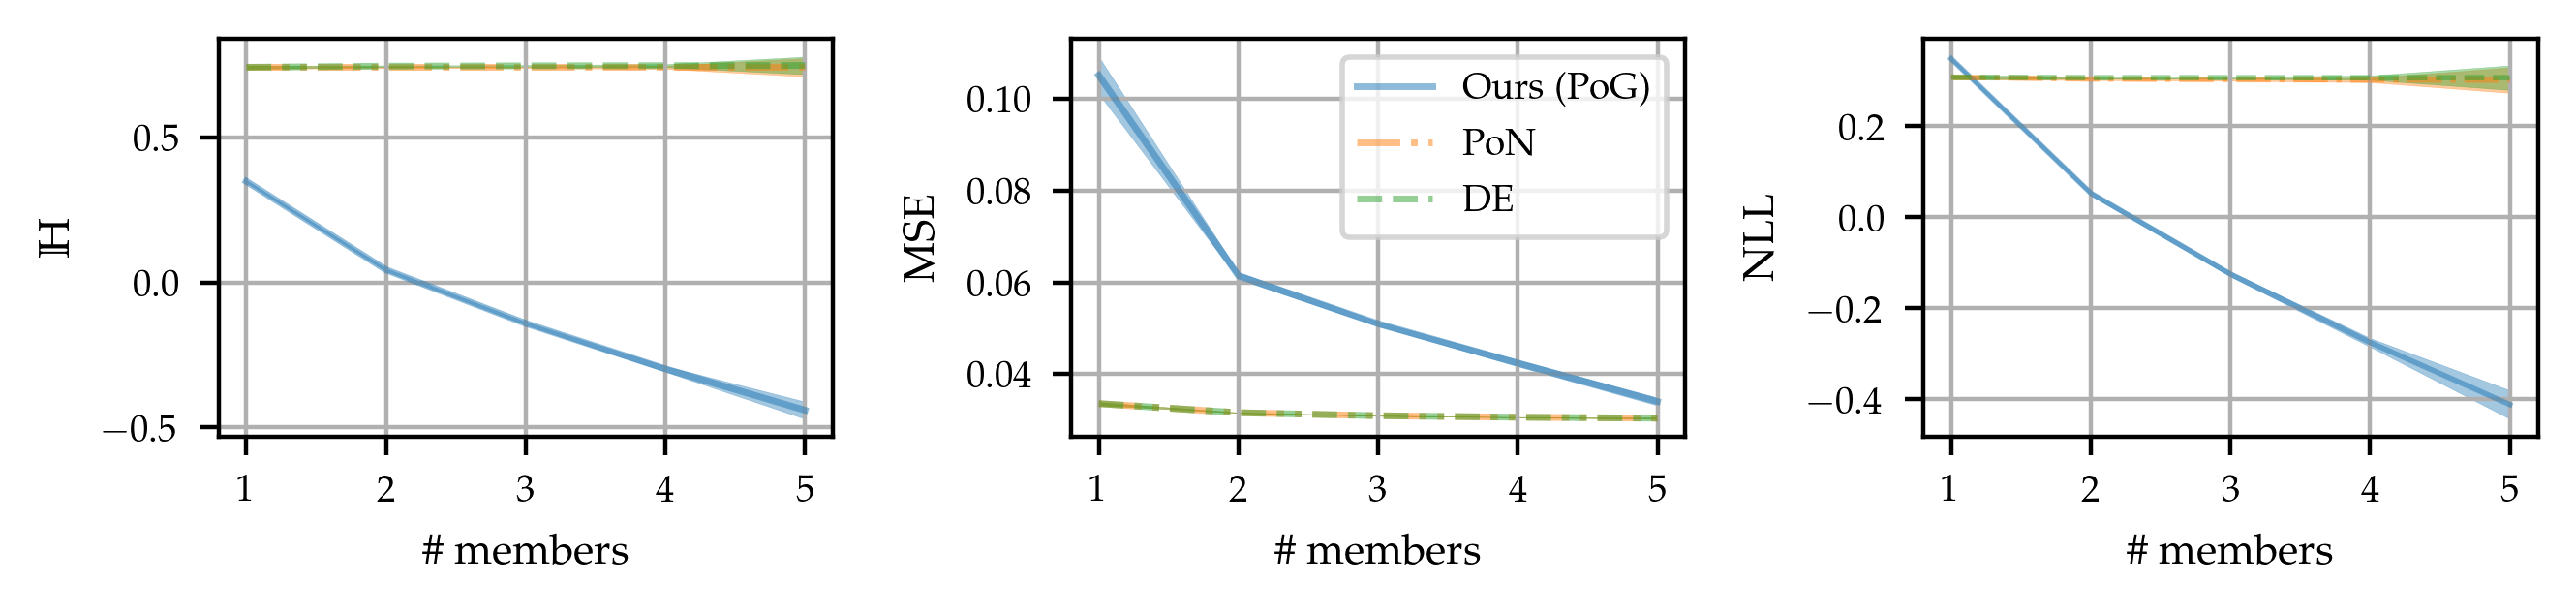

In [41]:
# matplotlib.style.use('default')
fig, axs = plt.subplots(1, 3, figsize=(text_width, text_width/4.), dpi=dpi, sharey=False, sharex=True, layout='tight')

names = {
    'PoG': 'Ours (PoG)',
    'Ens': 'DE',
    'PoN': 'PoN',
}

linestyles = {
    'PoG': '-',
    'Ens': '--',
    'PoN': '-.'
}

H_df = agg_df['H'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens']):
    x = H_df[H_df.model_name == model_name]['n_members']
    y = H_df[H_df.model_name == model_name]['mean']
    y_err = H_df[H_df.model_name == model_name]['std_err']

    axs[0].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5)
    axs[0].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[0].grid(0.3)
axs[0].set_ylabel('$\mathbb{H}$')
axs[0].set_xlabel('$\#$ members')
axs[0].set_xticks([1, 2, 3, 4, 5])

err_df = agg_df['mse'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens']):
    x = err_df[err_df.model_name == model_name]['n_members']
    y = err_df[err_df.model_name == model_name]['mean']
    y_err = err_df[err_df.model_name == model_name]['std_err']

    axs[1].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5, label=names[model_name])
    axs[1].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[1].grid(0.3)
axs[1].set_ylabel('MSE')
axs[1].set_xlabel('$\#$ members')
axs[1].set_xticks([1, 2, 3, 4, 5])

nll_df = agg_df[f'nll'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens']):
    x = nll_df[nll_df.model_name == model_name]['n_members']
    y = nll_df[nll_df.model_name == model_name]['mean']
    y_err = nll_df[nll_df.model_name == model_name]['std_err']

    axs[2].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1., alpha=0.5, label=names[model_name])
    axs[2].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[2].grid(0.2)
axs[2].set_ylabel(f'NLL')
axs[2].set_xlabel('$\#$ members')
axs[2].set_xticks([1, 2, 3, 4, 5])
axs[1].legend()

plt.savefig(f'toy_entropy_err_nll_evolution.pdf', dpi=dpi, bbox_inches='tight')